# How sensitive is the Steinberg signature to thermodynamic force?

## A tutorial for the `general-graphs` and `steinberg-utils` libraries
 
Here, we demonstrate how to use the `general-graphs` library developed for quantitative analysis of the Steinberg signature on any linear framework graph. In the development of this software, the NetworkX library for Python 3 was used. For more information on NetworkX, see https://networkx.org/documentation/stable/index.html

In this notebook, we will do the following. 

1. Create a random linear framework graph $G$ that is **strongly connected** and **fully reversible**.
2. Find a parameterization for $G$ such that $G$ exists in an equilibrium steady state 
3. Calculate the Steinberg signature for a specific parameterization of $G$
4. Drive the system represented by $G$ away from equilibrium by progressively perturbing a single parameter
5. Plot a force-area curve for any graph with any starting equilibrium parameterization



In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from general_graph_utils_main import *
from steinberg_utils_3vertex import *

In [2]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(14,12))
%config InlineBackend.figure_format = 'retina'

## 1. Create a general linear framework graph with a random number of nodes and randomly assigned edges.

A linear framework graph $G$ is a finite, directed graph with labeled edges and no self-loops (see I Mirzaev & J Gunawardena 2013 for more details on the linear framework and its equivalence to continuous time finite state Markov processes). Here, we use a linear framework graph to represent a Markovian system, such as biochemical reactions.

To generate a random linear framework graph, you first must decide the maximum number of nodes you want in your graph. Set that number as `n`. Then, define a directed graph `G` and an undirected graph `G_ud` as the outputs of the function `random_graph(n)`. `G` and `G_ud` are graph objects as defined by the NetworkX library.

`random_graph(n)` picks a random number between 3 and `n` to be the size of the graph, adds that many nodes to the graph, and then randomly assigns edges between the nodes such that the resulting graph is strongly connected and fully reversible.

It is necessary to have a directed and undirected version of the graph for the various functions that we will use going forward. Also, to clarify notation, $G$ refers to the mathematical object defined by the linear framework, while `G` and `G_ud` refer to graph objects defined in this numerical simulation using the NetworkX library.

In [3]:
G = nx.DiGraph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_edge(1, 2)
G.add_edge(2, 1)
#G.add_edge(1, 3)
#G.add_edge(3, 1)
G.add_edge(2, 3)
G.add_edge(3, 2)
G.add_edge(4, 3)
G.add_edge(3, 4)
G.add_edge(1, 4)
G.add_edge(4, 1)
G.add_edge(2, 4)
G.add_edge(4, 2)
#G.add_node(5)
#G.add_node(6)
#G.add_node(7)
#G.add_edge(6, 2)
#G.add_edge(2, 6)
#G.add_edge(1, 2)
#G.add_edge(2, 1)
#G.add_edge(6, 1)
#G.add_edge(1, 6)
#G.add_edge(6, 3)
#G.add_edge(3, 6)
#G.add_edge(6, 1)
#G.add_edge(1, 6)
#G.add_edge(1, 3)
#G.add_edge(3, 1)
#G.add_edge(7, 3)
#G.add_edge(3, 7)
#G.add_edge(1, 3)
#G.add_edge(3, 1)
#G.add_edge(7, 1)
#G.add_edge(1, 7)
#G.add_edge(6, 4)
#G.add_edge(4, 6)
#G.add_edge(4, 5)
#G.add_edge(5, 4)
#G.add_edge(5, 7)
#G.add_edge(7, 5)
#G.add_edge(7, 1)
#G.add_edge(1, 7)

In [4]:
G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_node(4)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
#G_ud.add_edge(1, 3)
#G_ud.add_edge(3, 1)
G_ud.add_edge(2, 3)
G_ud.add_edge(3, 2)
G_ud.add_edge(4, 3)
G_ud.add_edge(3, 4)
G_ud.add_edge(1, 4)
G_ud.add_edge(4, 1)
G_ud.add_edge(2, 4)
G_ud.add_edge(4, 2)
# G_ud.add_node(1)
# G_ud.add_node(2)
# G_ud.add_node(3)
# G_ud.add_node(4)
# G_ud.add_node(5)
# G_ud.add_node(6)
# G_ud.add_node(7)
# G_ud.add_edge(6, 2)
# G_ud.add_edge(2, 6)
# G_ud.add_edge(1, 2)
# G_ud.add_edge(2, 1)
# G_ud.add_edge(6, 1)
# G_ud.add_edge(1, 6)
# G_ud.add_edge(6, 3)
# G_ud.add_edge(3, 6)
# G_ud.add_edge(1, 3)
# G_ud.add_edge(3, 1)
# G_ud.add_edge(6, 1)
# G_ud.add_edge(1, 6)
# G_ud.add_edge(7, 3)
# G_ud.add_edge(3, 7)
# G_ud.add_edge(1, 3)
# G_ud.add_edge(3, 1)
# G_ud.add_edge(7, 1)
# G_ud.add_edge(1, 7)
# G_ud.add_edge(6, 4)
# G_ud.add_edge(4, 6)
# G_ud.add_edge(4, 5)
# G_ud.add_edge(5, 4)
# G_ud.add_edge(5, 7)
# G_ud.add_edge(7, 5)
# G_ud.add_edge(7, 1)
# G_ud.add_edge(1, 7)

In [5]:
print(G)

DiGraph with 4 nodes and 10 edges


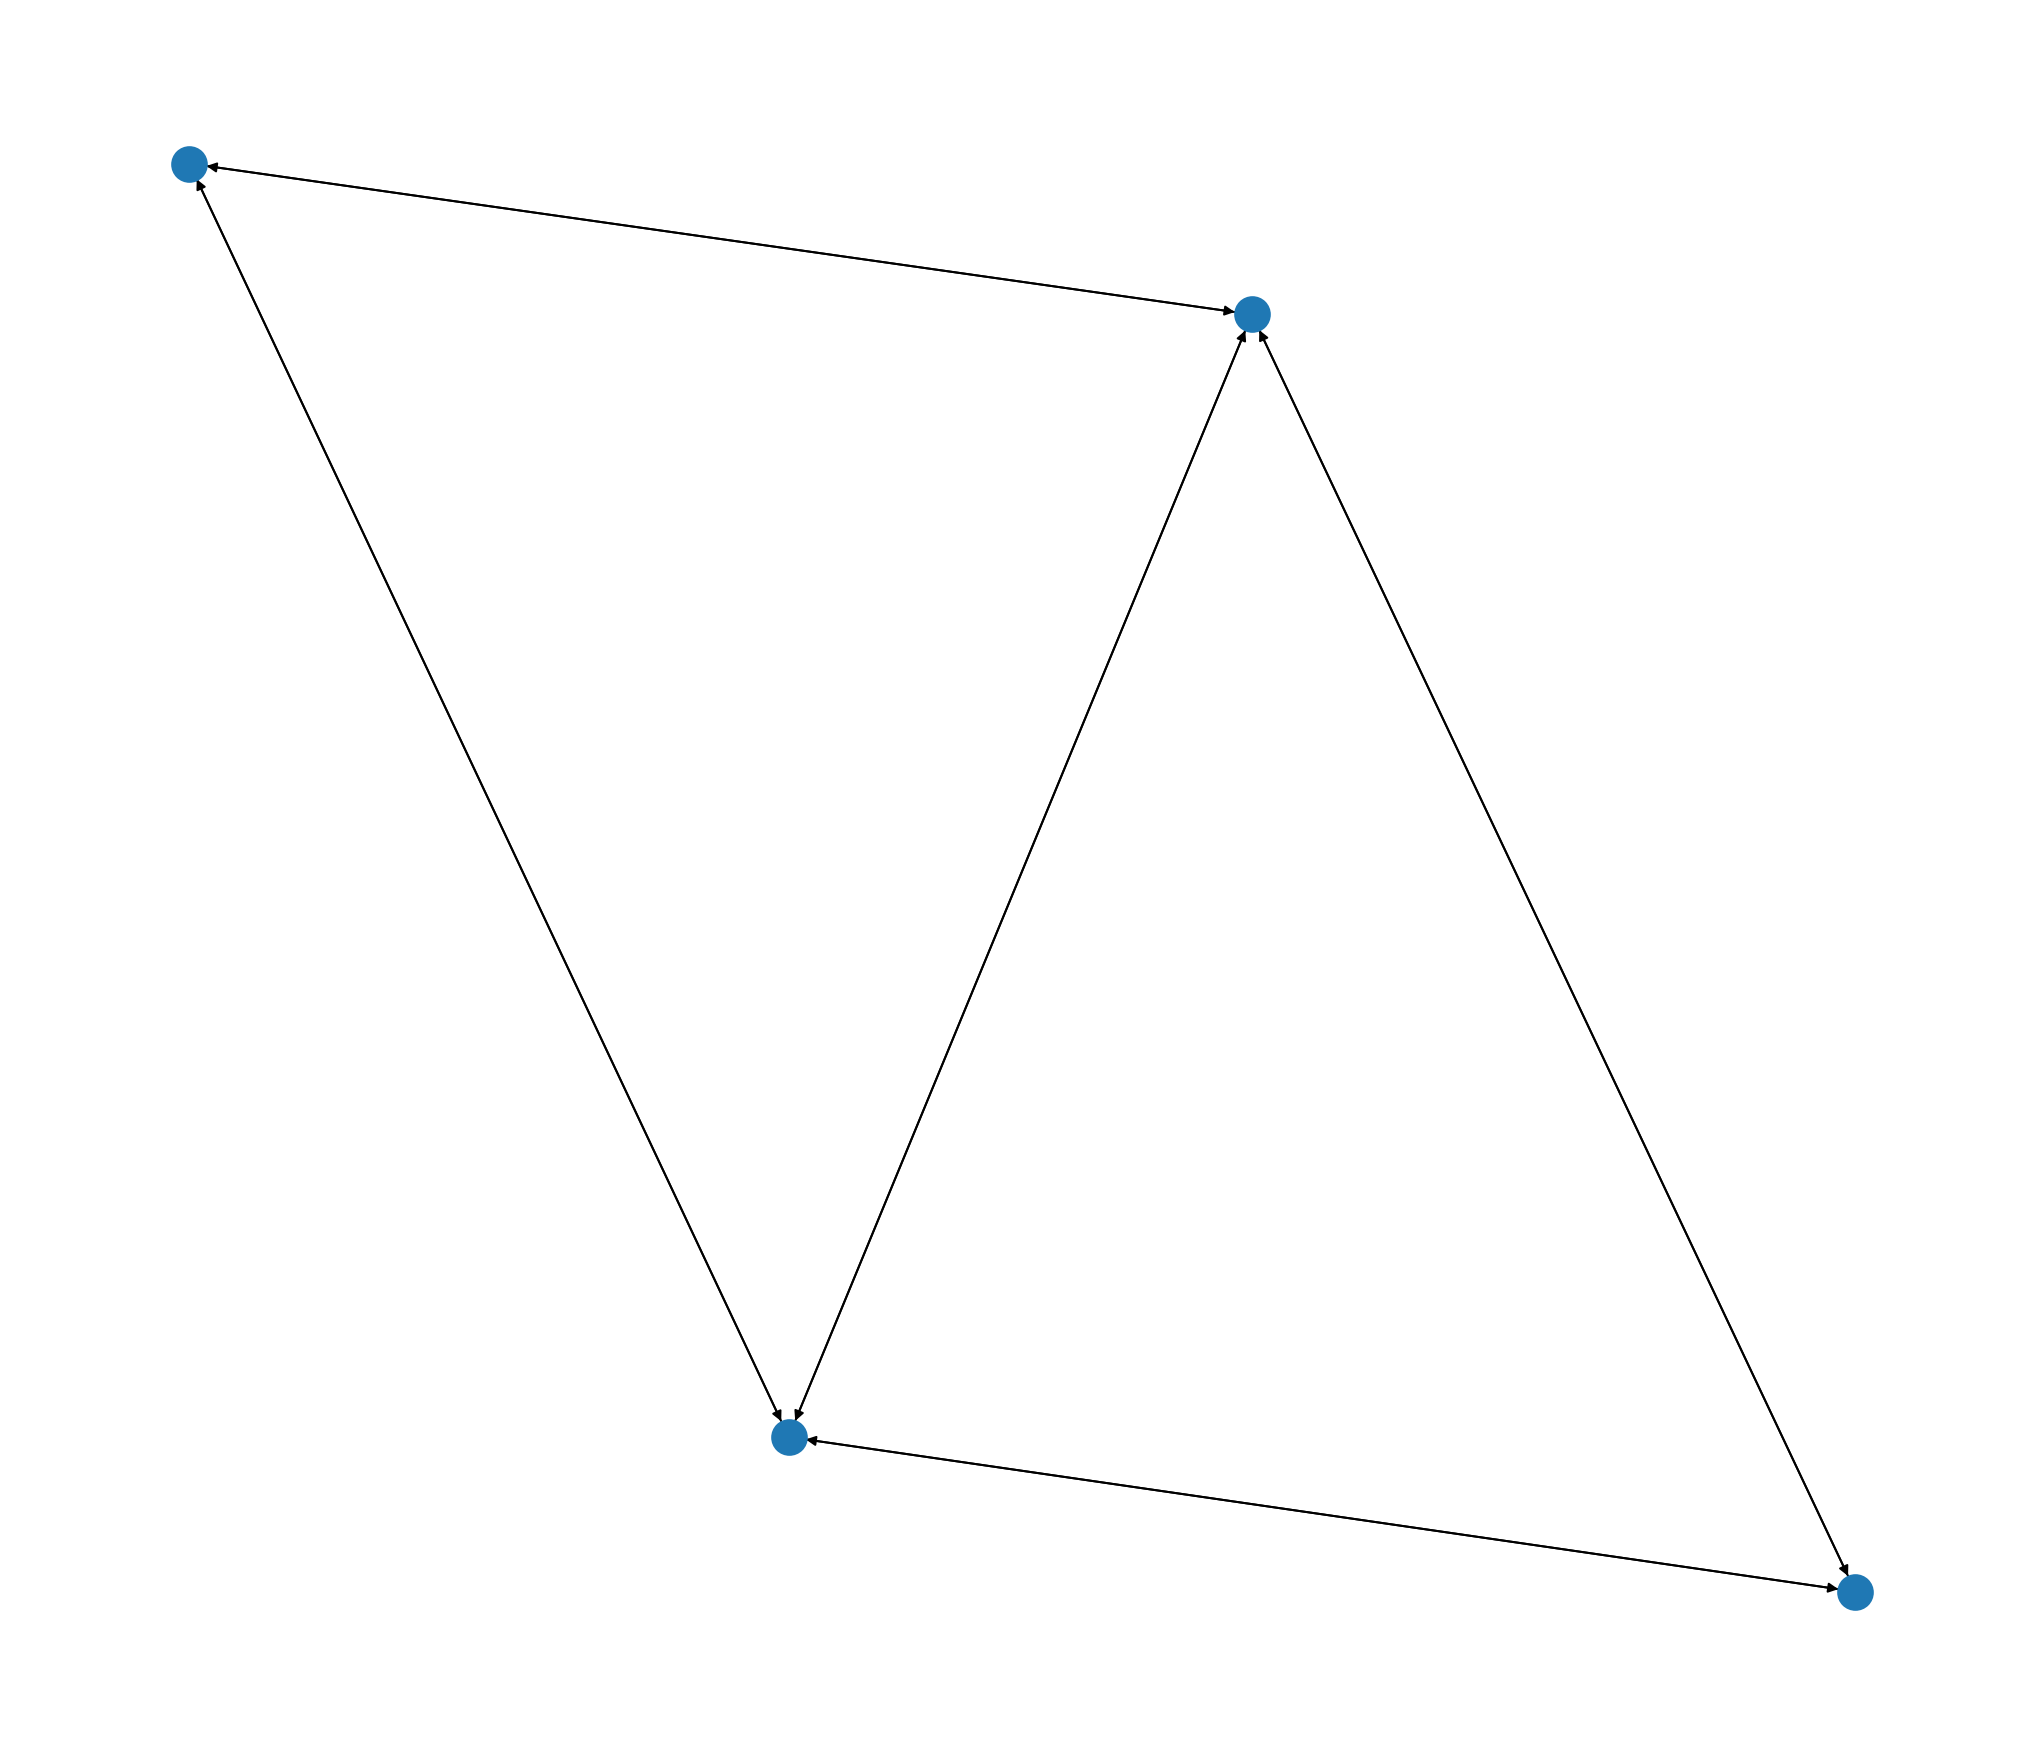

In [6]:
nx.draw(G)
plt.savefig('G_4_diagram_twocycle.png')

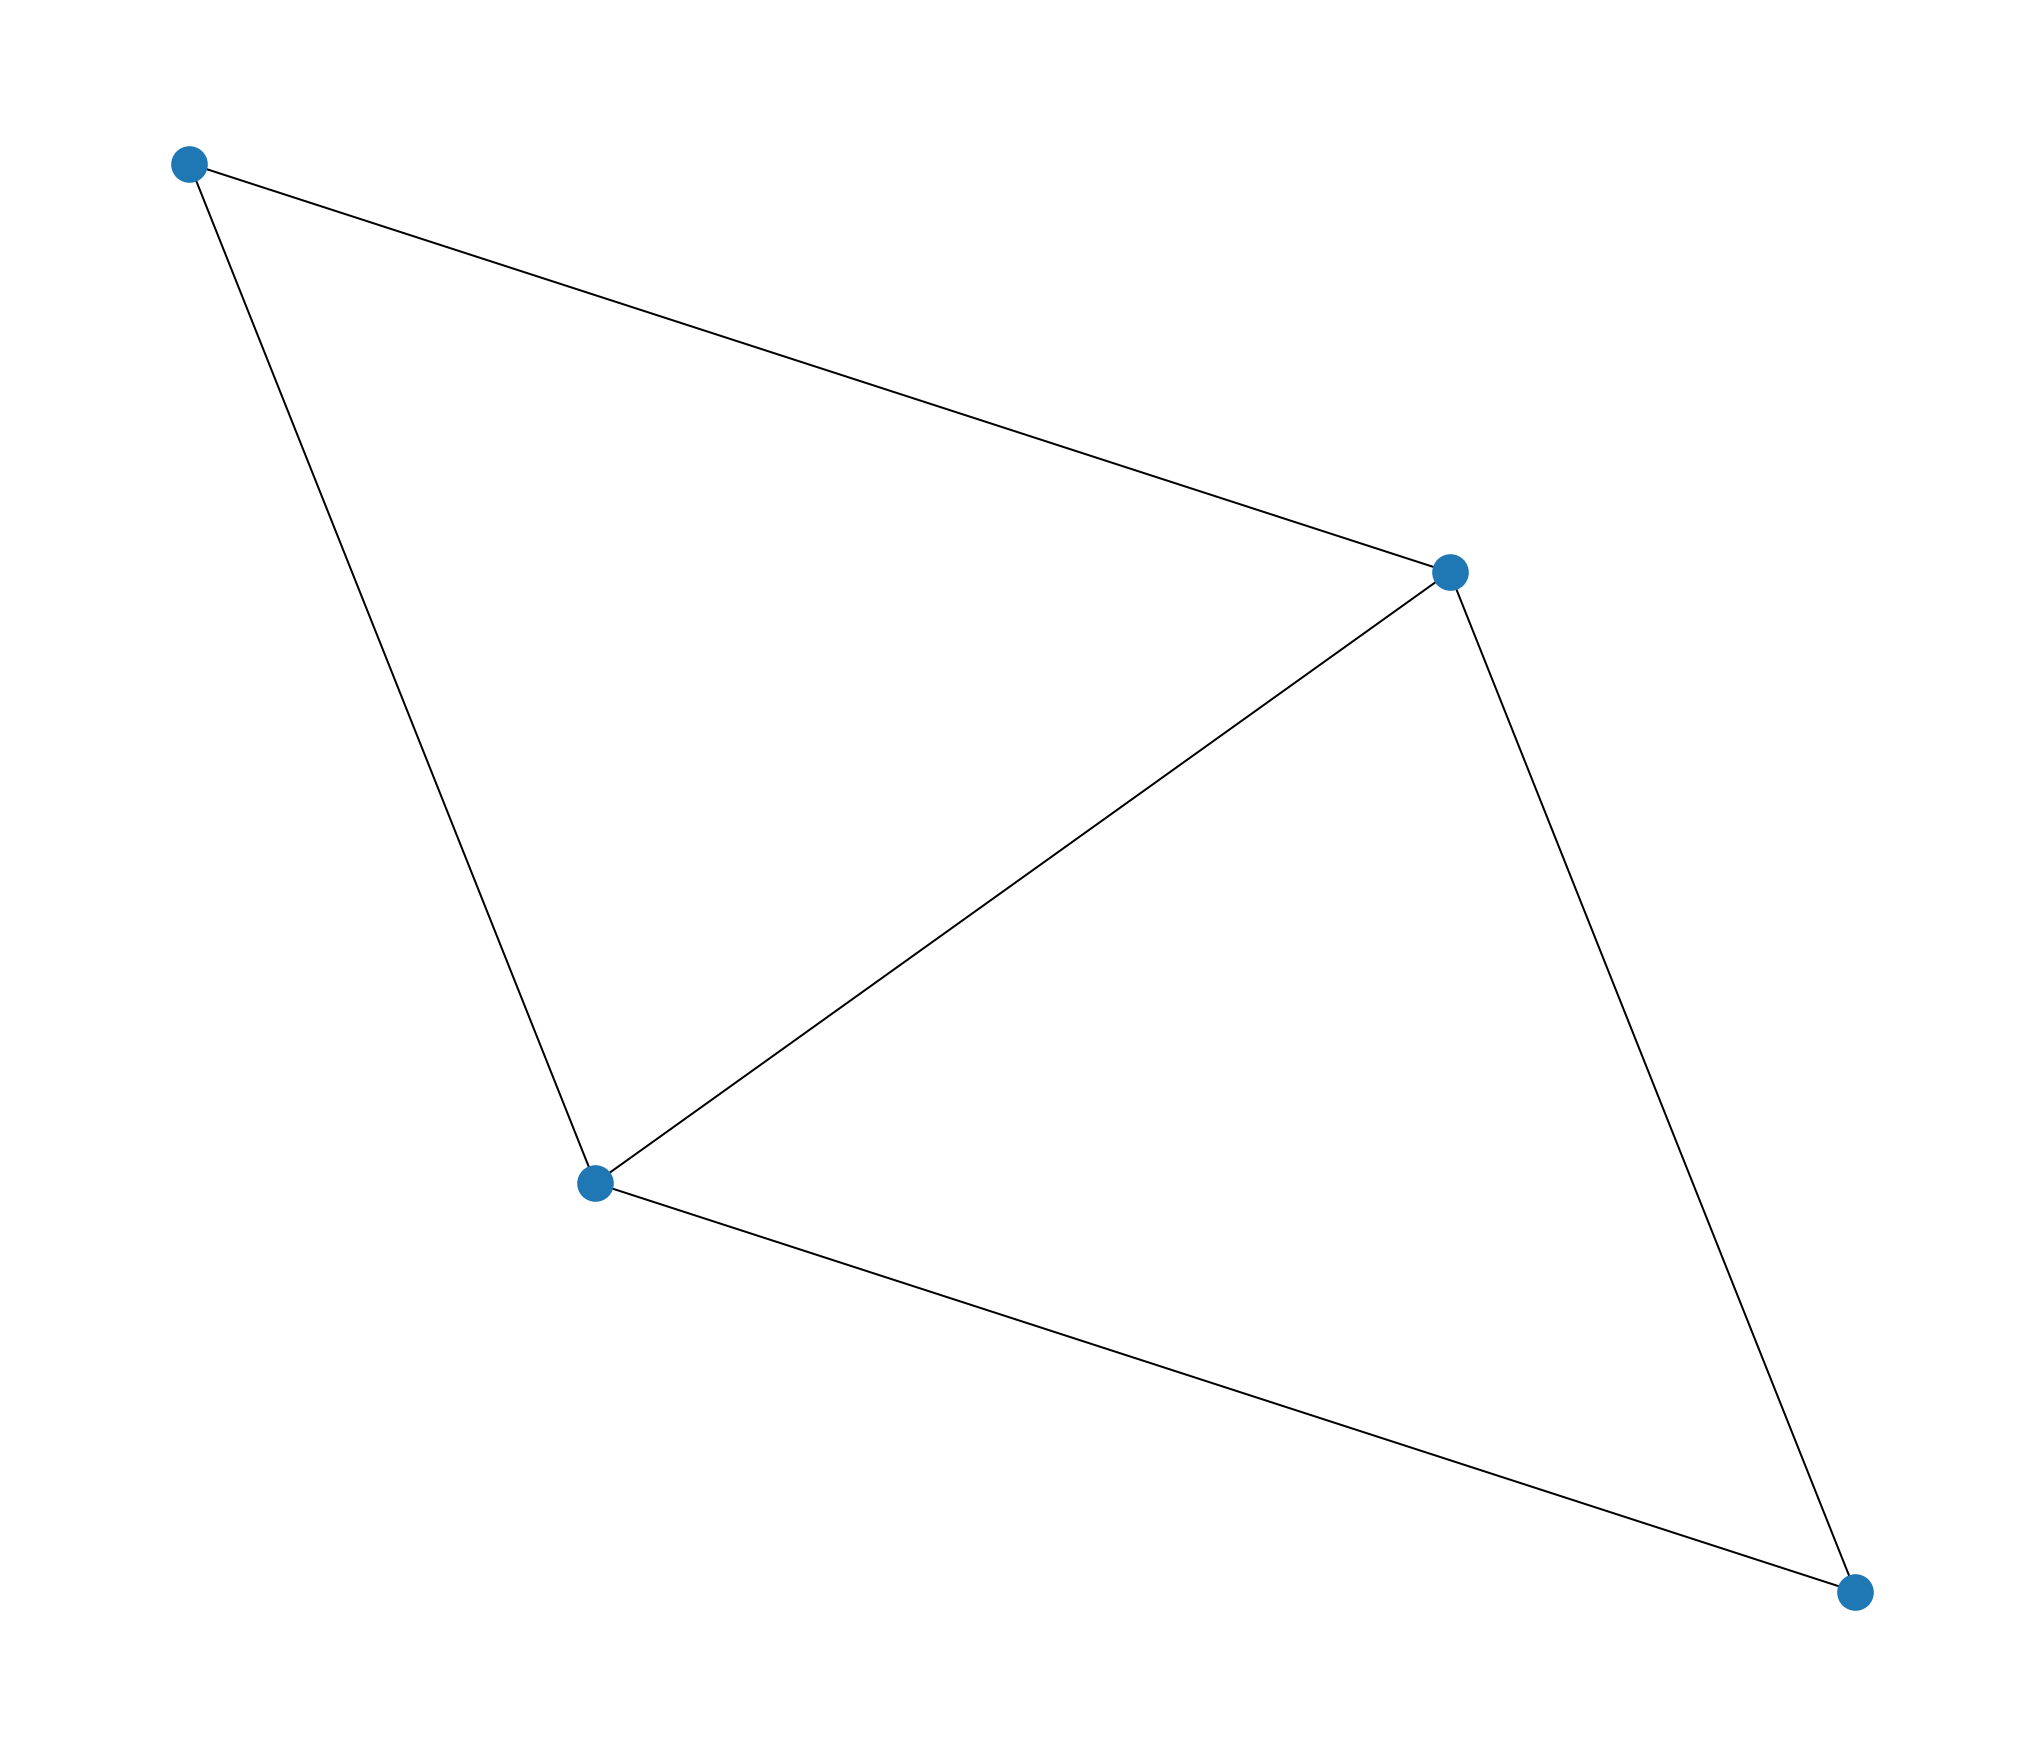

In [7]:
nx.draw(G_ud)

### 1.1. Create data structures containing the graph's structural information.

Next, we will assign structural information from `G` and `G_ud` to specific data structures, which will be necessary to compute quantities such as the cycle affinity.

Let's begin with the nodes and the edges of $G$.

`node_list`: a ***1D NumPy array*** of the nodes in $G$.

In [8]:
node_list = get_nodes(G)
print(node_list)

[1 2 3 4]


`edge_list`: a ***1D NumPy array*** of the edges in $G$. Each directed edge $i \to j$ between vertices $i$ and $j$ is represented as a list `[i j]`.

In [9]:
edge_list = get_edges(G)
print(edge_list)

[(1, 2), (1, 4), (2, 1), (2, 3), (2, 4), (3, 2), (3, 4), (4, 3), (4, 1), (4, 2)]


Let $C = i \leftrightharpoons 1 \leftrightharpoons 2 \leftrightharpoons \cdots \leftrightharpoons j \leftrightharpoons i$ represent a cycle of reversible edges in a graph. Linear framework graphs can be broken down into cycles (see the work of Terrell Hull and Johannes Schnakenberg for more details on taking a graph theoretic approach to stochastic thermodynamics), which is done by specifying a **cycle basis**.

To define a cycle basis, we take advantage of the NetworkX function `nx.cycle_basis`. More information can be found here: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.cycle_basis.html

`cycle_list`: a ***list of lists*** of the nodes involved in each cycle in $G$. Note that `G_ud`, not `G`, is required here.

`num_cycles`: number of cycles in $G$. This will be an essential parameter in later computations.

In [11]:
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)
print(cycle_list)
print(num_cycles)

[[2, 4, 1], [2, 3, 4]]
2


### 1.2. Specify a parameterization of $G$

To define edge labels for $G$, we use the following algorithm. If G is not already labeled, the labels are logarithmically sampled from the range $[10^{-3},10^3]$. 

The function returns the following data structures.

`label_dict`: a ***dictionary*** matching each edge to its corresponding label. The keys are the edges (listed as a tuple $(i,j)$ for each directed edge $i\to j$ and the values are the associated labels.

`label_list`: a ***1D NumPy array*** containing a list of the labels in $G$. The order is the same as in `edge_list`, which can be confirmed from `label_dict`

In [12]:
label_dict = {(1, 2): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 1.0,(2,4): 1.0, (4,2): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 1): 1.0, (4, 3): 1.0}
label_list = np.fromiter(label_dict.values(), dtype=float)
print(label_dict)
print(label_list)
len(label_list)


{(1, 2): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 1.0, (2, 4): 1.0, (4, 2): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 1): 1.0, (4, 3): 1.0}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


10

Going forward, it will be useful to specify which edges (and their corresponding labels) are associated with each cycle and to separate forward and backward traversals of each cycle. The next algorithm generates data structures that separate this information.

`cycle_edges_forward`: a ***list of lists*** where each element is a list of the edges going around one direction ("forward") of a given cycle

`cycle_edges_backward`: a ***list of lists*** where each element is a list of the edges going around the opposite direction ("backward") of a given cycle

`cycle_labels_forward`: a ***list of lists*** where each element is a list of the labels associated with the forward edges

`cycle_labels_backward`: a ***list of lists*** where each element is a list of the labels associated with the backward edges

Note that each of these data structures are ***lists of lists***. The indexing for all of them works as follows.

`cycle_edges_forward[i][j]` refers to edge `j` in cycle `i`. `cycle_labels_forward[i][j]` refers to the label on edge `j` in cycle `i`.

In [13]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [14]:
print(cycle_edges_forward)
print(cycle_edges_backward)

[[(2, 4), (4, 1), (1, 2)], [(2, 3), (3, 4), (4, 2)]]
[[(4, 2), (1, 4), (2, 1)], [(3, 2), (4, 3), (2, 4)]]


In [15]:
print(cycle_labels_forward)
print(cycle_labels_backward)

[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]


### 1.3. Calculate the cycle affinity for each cycle in the graph

The cycle affinity is a dimensionless quantity that serves as a measure of thermodynamic force (see J Schnakenberg 1986). Mathematically, we define the cycle affinity in the following way. Recall that $C = i \leftrightharpoons 1 \leftrightharpoons 2 \leftrightharpoons \cdots \leftrightharpoons j \leftrightharpoons i$ represents a cycle of reversible edges in a graph. For any cycle $C$, the cycle affinity $\tilde{A}(C)$ is given by

$$ \tilde{A}(C) = \log { \left ( \dfrac{\ell(i\to 1)\ell(1\to 2)\cdots \ell(j \to i)}{\ell(1\to i)\ell(2\to 1)\cdots \ell(i \to j)} \right ) } $$

where $\ell(a \to b)$ is the label on the directed edge $a \to b$. To compute this quantity for each cycle in our graph object `G`, we must complete the following steps.

1. Calculate the products of edge labels in each direction around each cycle.
2. Take the log of the ratio of the forward and backwards products for each cycle

`products_f`: a ***1D NumPy array*** where each element is the product of labels corresponding to the forward traversal of each cycle

`products_b`: a ***1D NumPy array*** where each element is the product of labels corresponding to the backward traversal of each cycle

In [16]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)

In [17]:
print(products_f)
print(products_b)

[1. 1.]
[1. 1.]


`total_affinities`: a ***1D NumPy array*** where each element is the thermodynamic force for each cycle in the graph, corresponding to their order in cycle_list

In [18]:
total_affinities = calculate_affinities(products_b, products_f, cycle_list)

In [19]:
print(total_affinities)

[0. 0.]


### 1.4 Calculate the Laplacian matrix $L$ and the steady state distribution $\pi$ of $G$

`L`: the Laplacian matrix of the graph

In [20]:
L = Laplacian_all(edge_list, label_list, node_list)
print(L)

[[-2.  1.  0.  1.]
 [ 1. -3.  1.  1.]
 [ 0.  1. -2.  1.]
 [ 1.  1.  1. -3.]]


`pi`: the steady-state distribution of $G$

In [21]:
eigvals, eigvecs = scipy.linalg.eig(L)
pi = np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)]).T
print(pi)
print(eigvals)

[[0.25]
 [0.25]
 [0.25]
 [0.25]]
[ 2.22044605e-16+0.j -2.00000000e+00+0.j -4.00000000e+00+0.j
 -4.00000000e+00+0.j]


## 2. Set the graph in an equilibrium steady state

Linear framework graphs represent biochemical systems. The vertices represent components of a system, and edges are treated as chemical reactions under mass-action kinetics with the labels as rate constants (Gunawardena 2012). The dynamics on this system relaxes to a **steady-state** when $dx/dt = 0$, where $x$ is a column vector of component amounts.

Furthermore, we can define two types of steady-states: equilibrium and non-equilibrium. An equilibrium steady-state is characterized by the lack of net fluxes of matter and energy. Detailed balance holds for each pair of reversible edges, and the cycle affinity for each cycle is equal to 0. 

In [22]:
cycle_labels_forward, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)

NameError: name 'initial_equilibrium_parameters' is not defined

In [23]:
cycle_labels_forward

[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]

In [24]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[0. 0.]


## 3. Calculate the Steinberg signature

The Steinberg signature is a signature of non-equilibrium conditions in Markovian systems. Using higher-order autocorrelation functions of the form $G^{\alpha,\beta}(\tau)$ and $G^{\beta,\alpha}(\tau)$, this method allows one to detect whether or not a given system obeys detailed balance. 

We can use the Steinberg signature to detect if the parameterization of a particular linear framework graph obeys detailed balance or not. The Steinberg signature takes multiple forms, including the following formula.

$$G^{\alpha,\beta}(\tau) = f^\alpha e^{L \tau} f^{* \beta} \pi$$

We will first define some quantities that will pass as variables in the Steinberg function. We will then compute the Laplacian matrix of the graph. Finally, when we have all the requisite components, we can compute the Steinberg signature.

`observable`: the vector $f$ in the above expression.

In [25]:
observable = make_observable(node_list)
print(observable)

[3. 5. 7. 9.]


`tau_n`: a vector of possible values of $\tau$. $\tau$ represents the interval.

In [26]:
tau, _ = define_tau_range(L, max_points=500, cap_factor=10.0)

In [27]:
label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)

NameError: name 'edge_tracker' is not defined

In [28]:
print(label_dict)

{(1, 2): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 1.0, (2, 4): 1.0, (4, 2): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 1): 1.0, (4, 3): 1.0}


In [29]:
L = np.around(Laplacian_all(edge_list, label_list, node_list),decimals=4)
print(L)

[[-2.  1.  0.  1.]
 [ 1. -3.  1.  1.]
 [ 0.  1. -2.  1.]
 [ 1.  1.  1. -3.]]


`t`: forward higher-order autocorrelation function $G^{\alpha,\beta}(\tau)$

`t_rev`: reverse higher-order autocorrelation function $G^{\beta, \alpha}(\tau)$

In [30]:
def autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3):
    """
    Calculates the analytical solution for forward and reverse higher-order autocorrelation functions for a particular Laplacian matrix
    
    Parameters
    ----------
    observable : 1D array
        possible values of observable (which is a state function on the Markov process)
    L : NxN array
        column-based Laplacian matrix of linear framework graph with N vertices
    tau_n : 1D array
        range of intervals between values of observable taken by system
    alpha : scalar
        exponent applied to observable
    beta : scalar
        exponent applied to transpose of observable
    
    Returns
    -------
    t : 1D array
        forward autocorrelation function values
    t_rev : 1D array
        reverse autocorrelation function values
    
    """
    f = np.array([observable],dtype=np.float128)
    fstar = f.T
    
    # calculate the stationary distribution of the Markov process
    eigvals, eigvecs = scipy.linalg.eig(L)
    pi = np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)]).T
    
    # initialize forward and reverse autocorrelation function arrays
    t = np.zeros(len(tau_n),dtype=np.float128)
    t_rev = np.zeros(len(tau_n),dtype=np.float128)
    
    list_result = list(map(lambda i: scipy.linalg.expm(L*i), tau_n))
    
    # populate arrays with analytical solution to autocorrelation function
    for i in range(len(tau_n)):
        t[i] = f**alpha @ list_result[i] @(fstar ** beta * pi)
        t_rev[i] = f**beta @ list_result[i] @(fstar ** alpha * pi)
        
    return t, t_rev

In [37]:
%%time
t, t_rev = autocorrelation_analytical(observable,L,tau,alpha=1,beta=3)

CPU times: user 112 ms, sys: 3.18 ms, total: 115 ms
Wall time: 120 ms


In [38]:
area = np.abs(np.trapz(t)-np.trapz(t_rev))
print(area)

4.9794834922067821026e-11


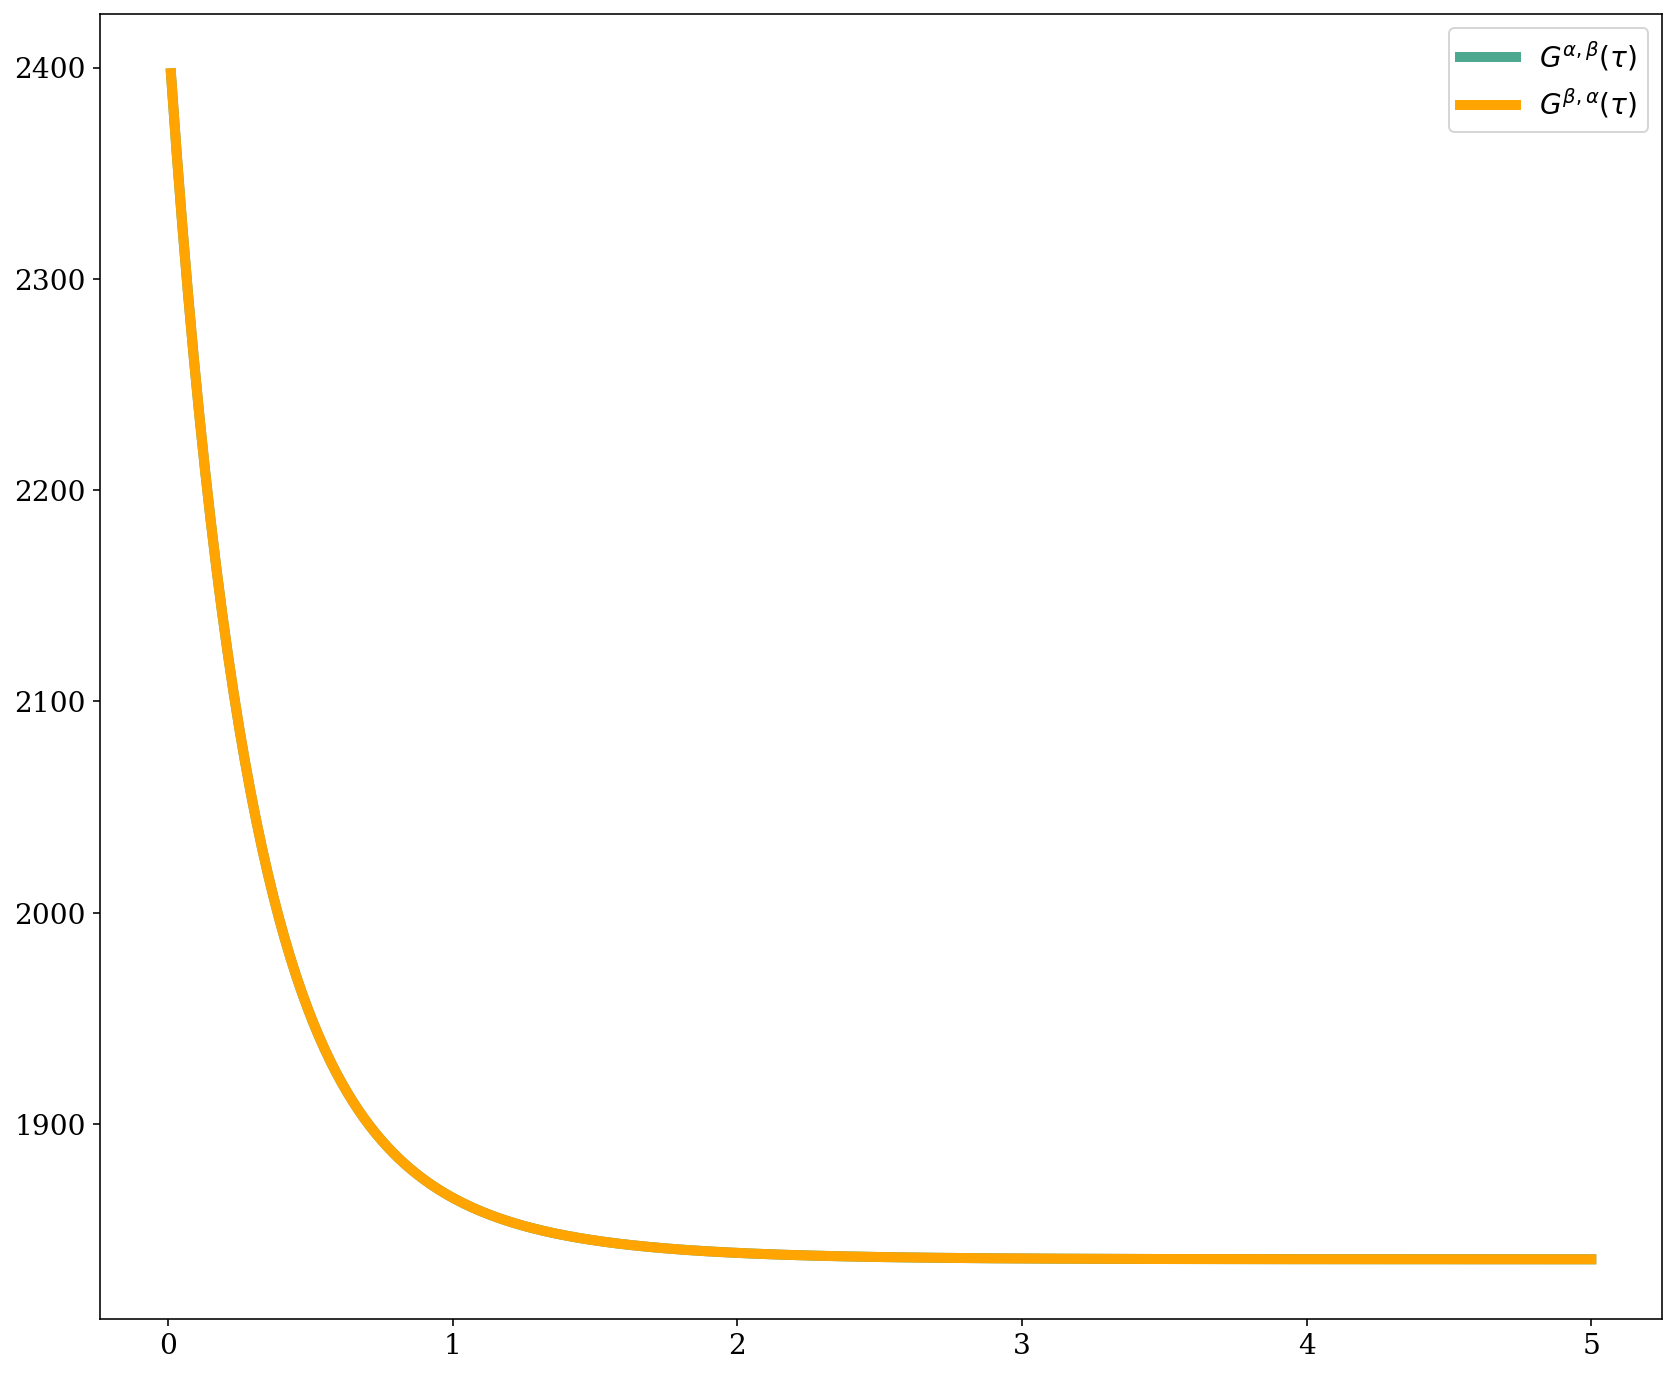

In [40]:
fig = plt.figure()
plt.plot(tau,t_rev,color='#4CA98F',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.plot(tau,t,c= '#FFA400',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.legend()

In [42]:
t, t_rev = autocorrelation_analytical(observable,L,tau,alpha=1,beta=3)

In [43]:
area = np.abs(np.trapz(t)-np.trapz(t_rev))
print(area)

4.9794834922067821026e-11


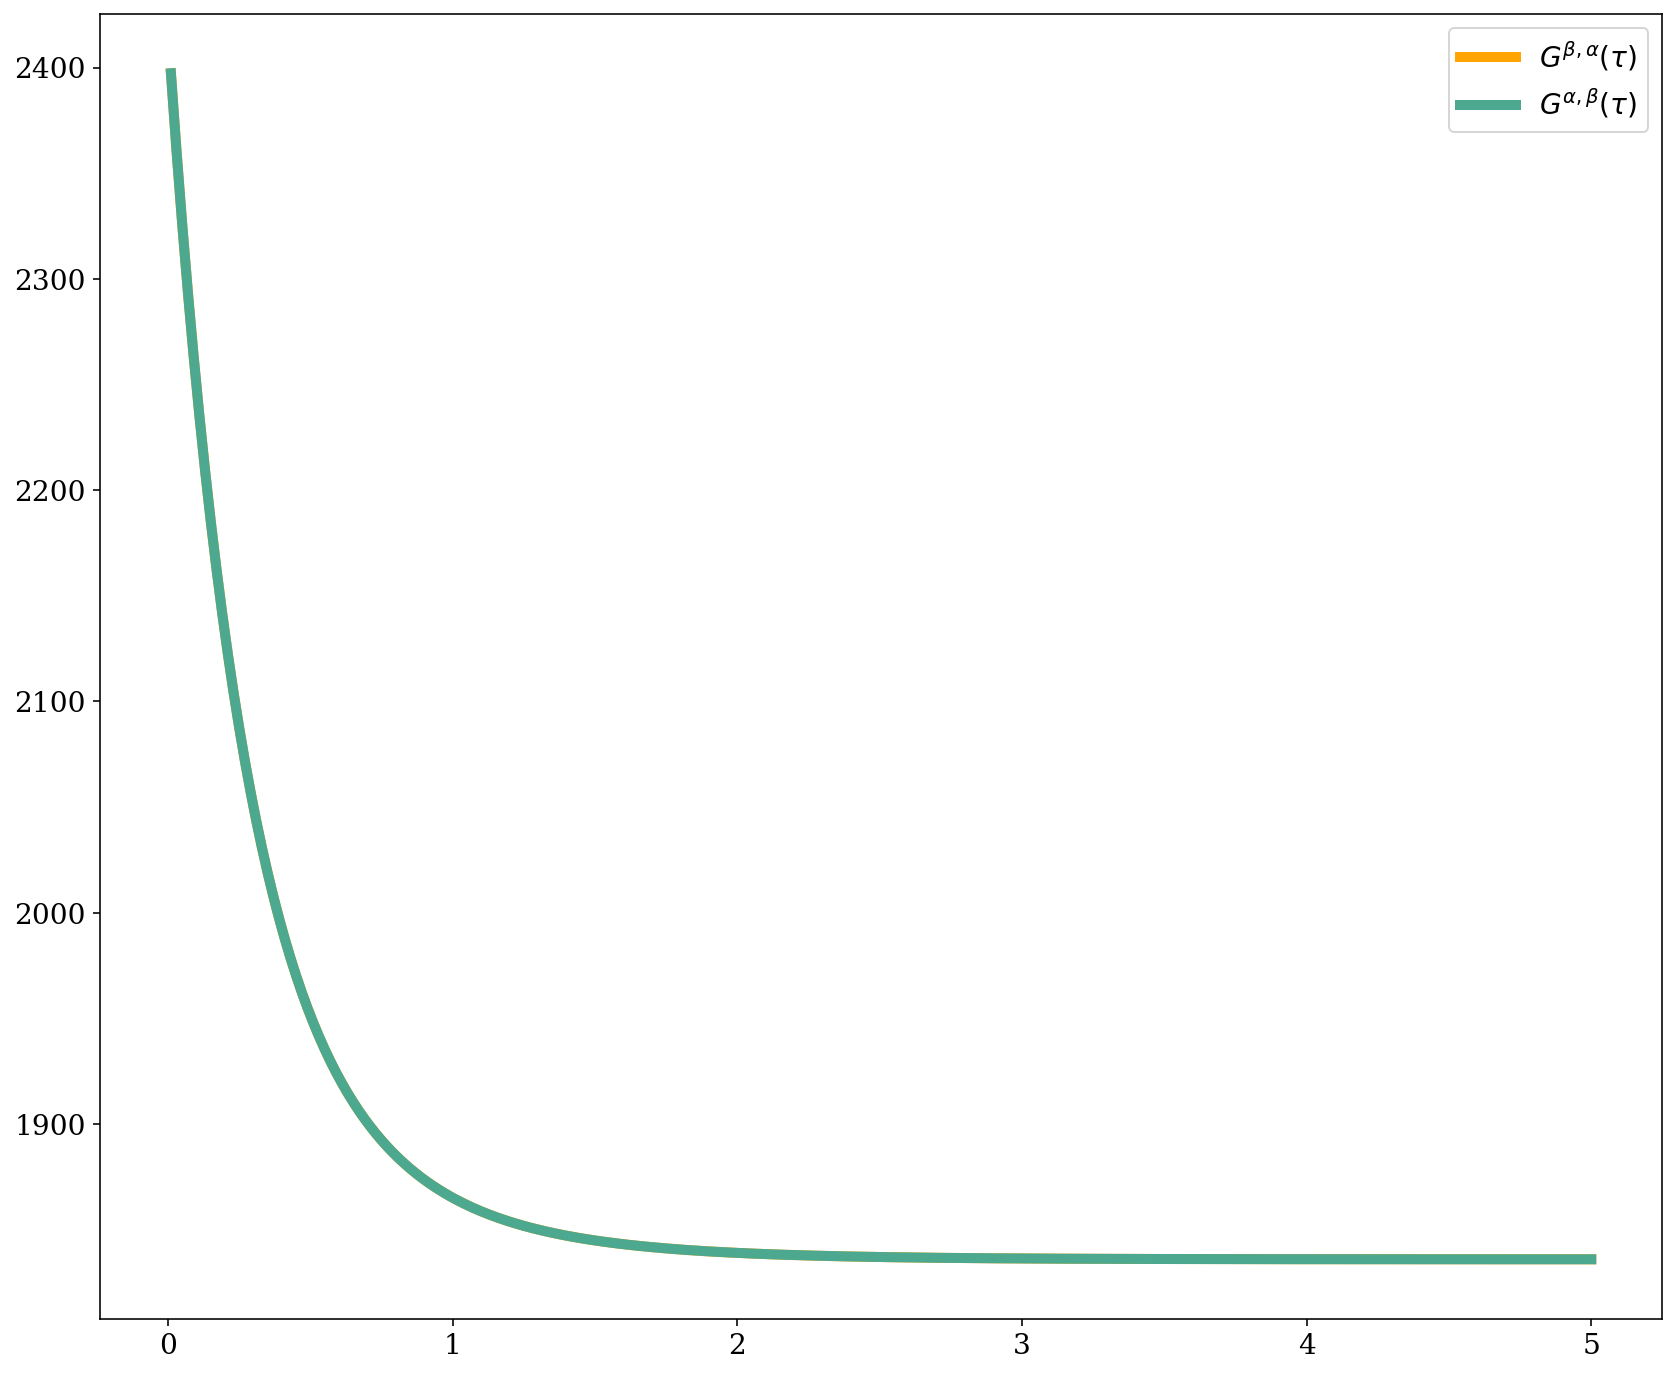

In [45]:
fig = plt.figure()
plt.plot(tau,t,c= '#FFA400',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.plot(tau,t_rev,color='#4CA98F',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.legend()
#fig.savefig('max tau 10 not big enough for this set.png', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

## 4. Perturb a single parameter progressively from its equilibrium value

The goal of developing this software was to determine the sensitivity of the Steinberg signature to the thermodynamic force of the underlying system.

In [48]:
cycle_idx = 0 #np.random.choice(np.arange(num_cycles))
cycle_idx

0

In [49]:
edge_idx = 2 #np.random.choice(np.arange(len(cycle_labels_forward[cycle_idx])))
edge_idx

2

In [50]:
param_choice = cycle_labels_forward[cycle_idx][edge_idx]
print(param_choice)
edge = cycle_edges_forward[0][2]
print(edge)

1.0
(1, 2)


In [51]:
N = 1000
all_affinities = np.zeros((N,num_cycles))
all_areas = np.zeros((N,1))
param_changes = np.zeros((N,1))
tau, _ = define_tau_range(L, max_points=500, cap_factor=10.0)

In [52]:
print(cycle_list)

[[2, 4, 1], [2, 3, 4]]


In [54]:
def initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward):
    """
    Initializes a graph with a particular parameterization in an equilibrium steady state
    
    Parameters
    ----------
    cycle_list : list of lists
        each element is a list of the nodes connected in a given cycle.

    cycle_edges_forward : list of lists
        each element is a list of the edges going around one direction of a given cycle

    cycle_labels_forward : list of lists
        each element is a list of the labels going around one direction of a given cycle
    
    cycle_labels_backward : list of lists
        each element is a list of the labels going around the opposite direction of a given cycle

    Returns
    -------
    
    cycle_labels_forward : list of lists
        updated with new values for certain edges
        
    edge_tracker : list of lists
        list of edges with labels that were changed to initialize the system in an equilibrium steady state
    
    """
    
    num_cycles = len(cycle_list)
    edge_tracker = []
    
    # for each cycle in cycle_list
    for i in range(num_cycles):
        for j in range(len(cycle_list[i])):
            
            # if the edge is already in edge_tracker, move on
            if cycle_edges_forward[i][j] in edge_tracker:
                pass
            
            # otherwise, change the value of one edge in the cycle such that the cycle affinity is 0
            else:
                cycle_labels_forward[i][j] = 1/(np.prod(cycle_labels_forward[i])/(cycle_labels_forward[i][j]*np.prod(cycle_labels_backward[i])))
                
                # add that edge to edge_tracker
                edge_tracker.append(cycle_edges_forward[i][j])
    
    return cycle_labels_forward, edge_tracker

def reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list):
    """
    Initializes a graph with a particular parameterization in an equilibrium steady state
    
    Parameters
    ----------
    
    cycle_list : list of lists
        each element is a list of the nodes connected in a given cycle.
    
    cycle_labels_forward : list of lists
        updated with new values for certain edges
        
    edge_tracker : list of lists
        list of edges with labels that were changed to initialize the system in an equilibrium steady state
        
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels
        
    label_list : 1D numpy array
        list of edge labels in G
    
    Returns
    -------
    
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels (updated with equilibrium changes)
        
    label_list : 1D numpy array
        list of edge labels in G (updated with equilibrium changes
    """
    
    num_cycles = len(cycle_list)
    
    for i in range(num_cycles):
        label_dict[edge_tracker[i]] = cycle_labels_forward[i][0]
        
    label_list = np.fromiter(label_dict.values(), dtype=float)
    
    return label_dict, label_list

In [55]:
cycle_labels_forward, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)

In [56]:
label_dict

{(1, 2): 1.0,
 (1, 4): 1.0,
 (2, 1): 1.0,
 (2, 3): 1.0,
 (2, 4): 1.0,
 (4, 2): 1.0,
 (3, 2): 1.0,
 (3, 4): 1.0,
 (4, 1): 1.0,
 (4, 3): 1.0}

In [57]:
for i in tqdm(range(0,N)):
    
    # calculate affinity + record
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f,products_b,cycle_list)
    all_affinities[i] = total_affinities
        
    # calculate area + record
    label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
    L = Laplacian_all(edge_list,label_list,node_list)
    tau, _ = define_tau_range(L, max_points=500, cap_factor=10.0)
    t, t_rev = autocorrelation_analytical(observable,L,tau,alpha=1,beta=3)
    all_areas[i] = np.abs(np.trapz(t)-np.trapz(t_rev))
    
    # perturb parameter + record
    param_changes[i] = cycle_labels_forward[0][0]
    cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01

100%|███████████████████████████████████████| 1000/1000 [01:34<00:00, 10.58it/s]


## 5. Plot the resulting force-area curve

In [58]:
print(label_dict)

{(1, 2): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 1.0, (2, 4): 20751.639245360224, (4, 2): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 1): 1.0, (4, 3): 1.0}


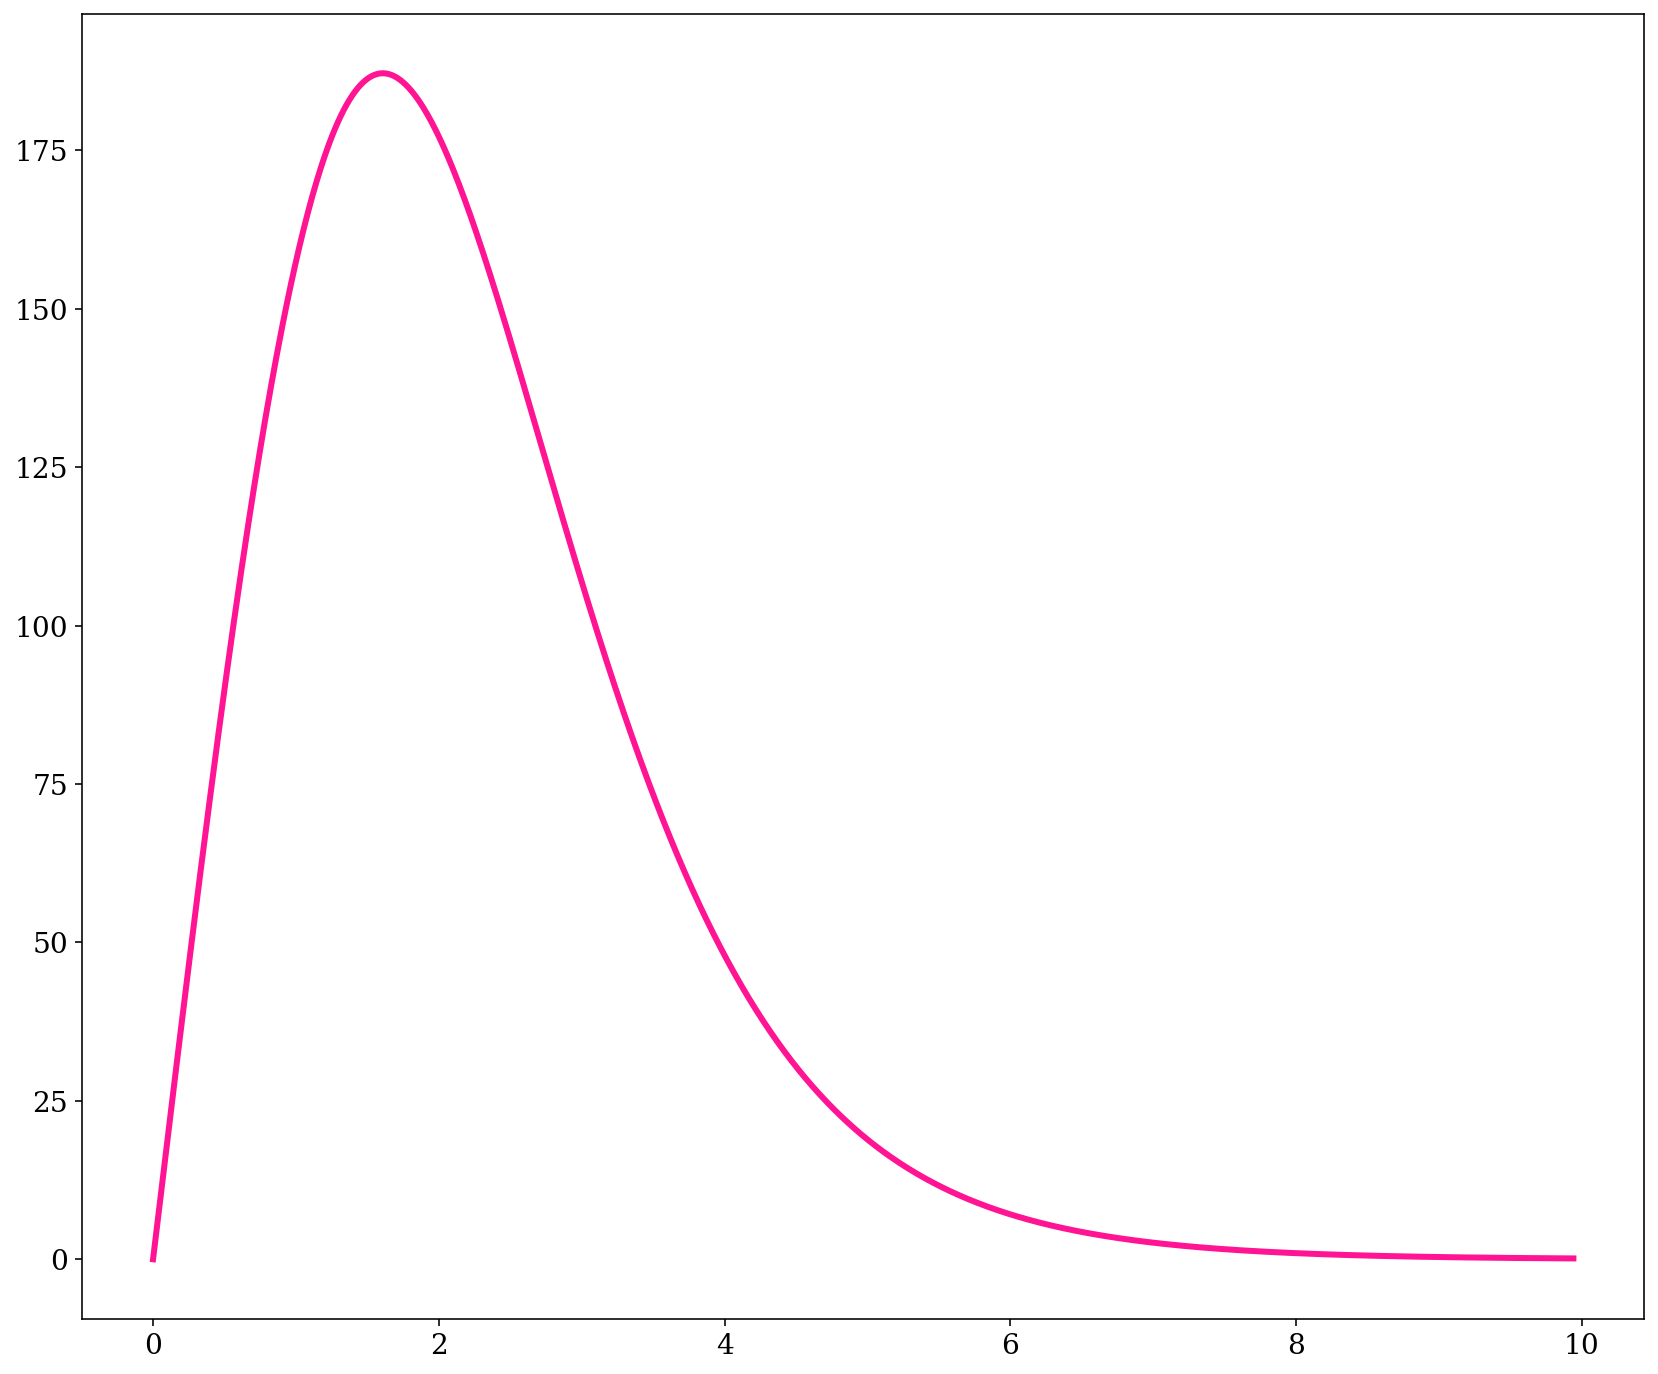

In [60]:
fig = plt.figure()
plt.plot(all_affinities[:,0],all_areas, linewidth=3, color='deeppink')
fig.savefig('4v2c_allones_newtau.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
#fig.savefig('figure4B.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

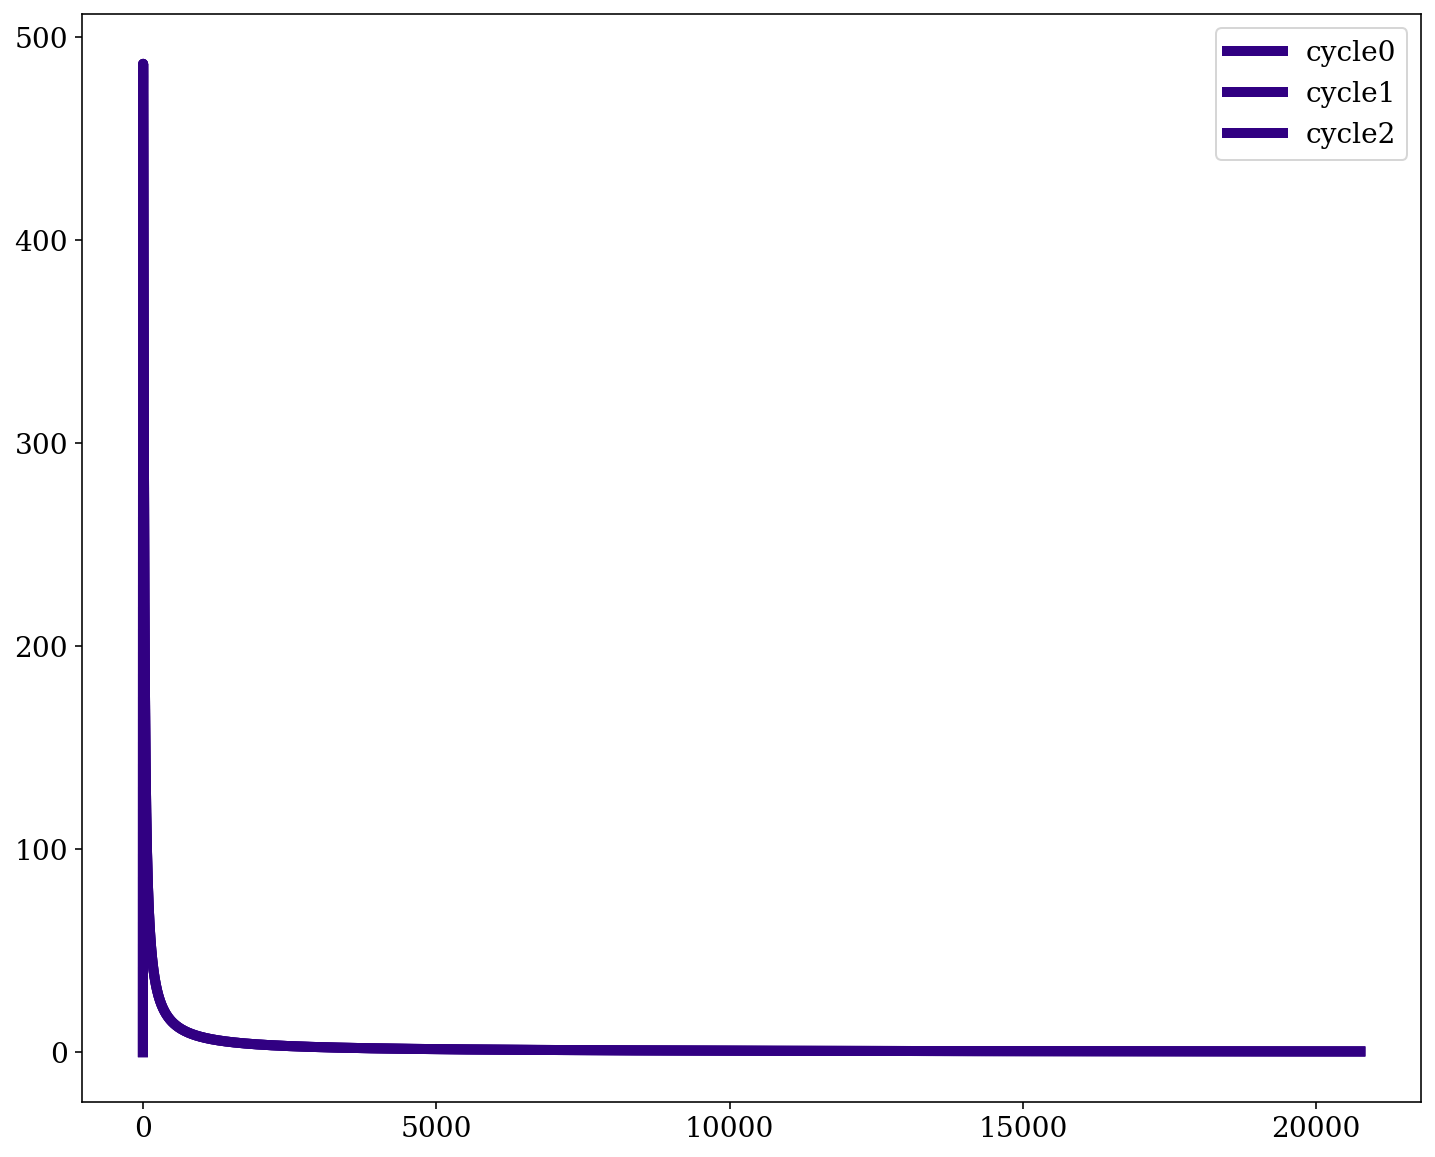

In [171]:
fig = plt.figure()
for i in range(0,num_cycles):
    plt.plot(param_changes,all_areas,linewidth=5, color = '#310082',label='cycle'+str(i))
plt.legend()
#plt.xlim(0,80000)
#fig.savefig('forcearea_energetic_edge.png', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

### 5.1 Identifying the peak and the asymptote of the force-area curve

### Peak $A^{\alpha,\beta}_{\text{max}}$

The changed parameter for this graph is (3,2)

In [172]:
print(label_dict)

{(1, 2): 1.0, (1, 3): 1.0, (3, 1): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 1.0, (2, 4): 1.0, (3, 2): 1.0, (3, 4): 20751.639245360224, (4, 1): 1.0, (4, 2): 1.0, (4, 3): 1.0}


In [55]:
idx = np.argmax(all_areas)
print(idx)

156


In [56]:
all_areas[idx]

array([1533.75372614])

In [51]:
changed = param_changes[idx]
print(changed)

[1.]


In [52]:
label_dict.keys()

dict_keys([(1, 6), (1, 3), (1, 7), (1, 2), (2, 6), (2, 1), (3, 6), (3, 7), (3, 1), (4, 6), (4, 5), (5, 4), (5, 7), (6, 2), (6, 3), (6, 4), (6, 1), (7, 5), (7, 1), (7, 3)])

In [53]:
label_dict[(3, 2)] = changed[0]

In [54]:
print(label_dict)

{(1, 6): 1.0, (1, 3): 1.0, (1, 7): 1.0, (1, 2): 1.0, (2, 6): 1.0, (2, 1): 1.0, (3, 6): 1.0, (3, 7): 20751.639245360224, (3, 1): 1.0, (4, 6): 1.0, (4, 5): 1.0, (5, 4): 1.0, (5, 7): 1.0, (6, 2): 1.0, (6, 3): 1.0, (6, 4): 1.0, (6, 1): 1.0, (7, 5): 1.0, (7, 1): 1.0, (7, 3): 1.0, (3, 2): 1.0}


In [376]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [377]:
L = np.around(Laplacian_all(edge_list, label_list, node_list),decimals=4)

In [378]:
t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)

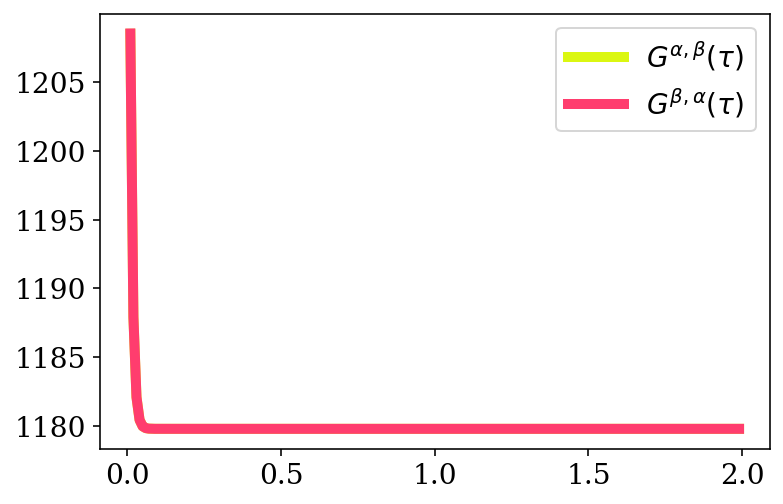

In [379]:
fig = plt.figure()
plt.plot(tau_n,t,color='#DBF711',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.plot(tau_n,t_rev,c= '#FF3D6E',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.legend()
#fig.savefig('nonequilibrium-autocorrelation-official-2.png', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
#fig.savefig('peak-autocorrelation-official-VERYNICE.png', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

### Asymptote $\lim_{x \to \infty} A^{\alpha,\beta}$

In [380]:
all_areas[-1]

array([3.00985801e-05])

In [381]:
changed = param_changes[-1]
print(changed)

[3833.69877364]


In [382]:
label_dict[(3, 2)] = changed[0]

In [383]:
print(label_dict)

{(1, 3): 0.44276, (1, 2): 0.00691, (2, 1): 542.35068, (2, 3): 79.17629, (3, 1): 81.08508, (3, 2): 3833.6987736362503}


In [384]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [385]:
print(label_list)

[4.42760000e-01 6.91000000e-03 5.42350680e+02 7.91762900e+01
 8.10850800e+01 3.83369877e+03]


In [386]:
L = np.around(Laplacian_all(edge_list, label_list, node_list),decimals=4)

In [387]:
t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)

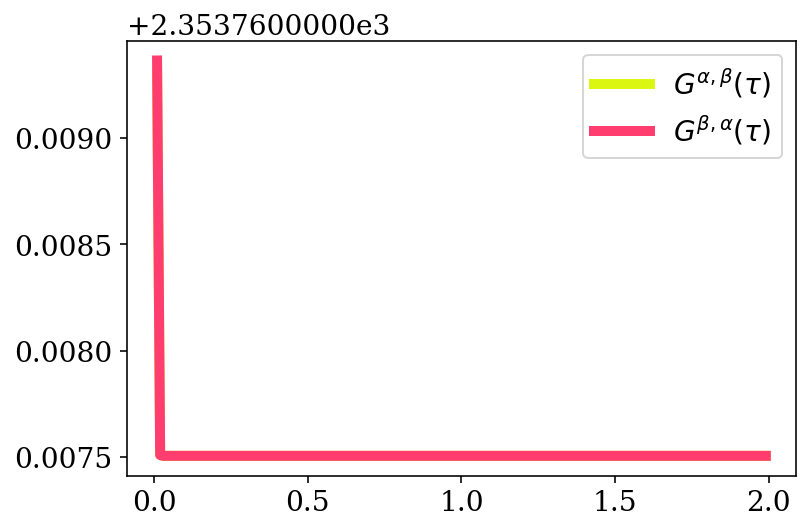

In [388]:
fig = plt.figure()
plt.plot(tau_n,t,color='#DBF711',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.plot(tau_n,t_rev,c= '#FF3D6E',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.legend()
#fig.savefig('asymptote-autocorrelation-official-2.png', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

### Is the asymptote less than the peak?

In [389]:
peak = all_areas[idx][0]
asymptote = all_areas[-1][0]

In [390]:
print(peak)
print(asymptote)

0.018590327701986098
3.009858005498245e-05


In [391]:
(peak/asymptote > 1) == True

True

### 100 parameterizations for the 3-vertex graph

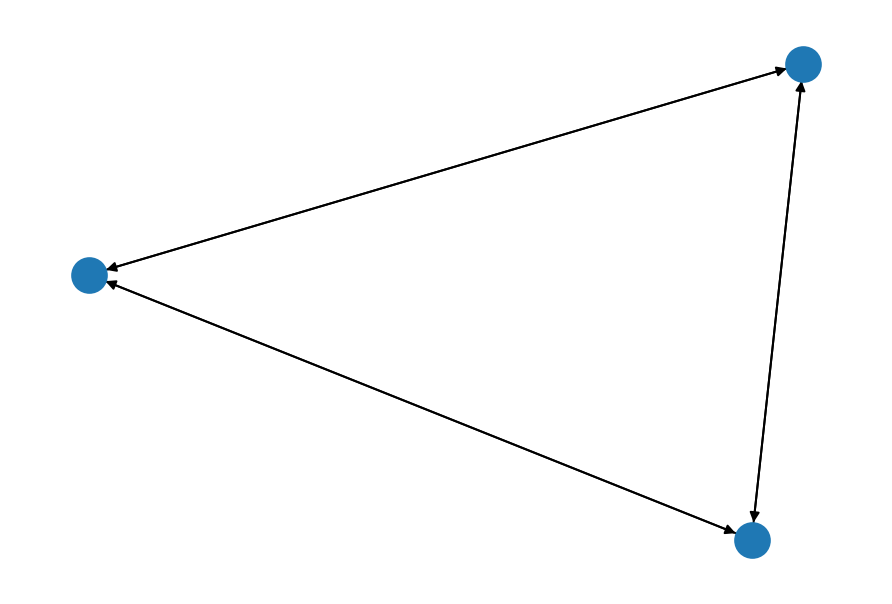

In [392]:
nx.draw(G)

In [178]:
print(node_list)
print()
print(edge_list)
print()
print(cycle_list)

[1 2 3]

[[1 2]
 [1 3]
 [2 3]
 [2 1]
 [3 1]
 [3 2]]

[[2, 3, 1]]


In [179]:
M = 100
N = 1000

all_peaks = np.zeros((M,1))
all_asymptotes = np.zeros((M,1))
peak_affinities = np.zeros((M,num_cycles))

In [217]:
# new equilibrium parameter set
label_dict, label_list = get_labels(G)
print(label_dict)
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
print(cycle_labels_forward)
print(cycle_labels_backward)
cycle_labels_forward_eq, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)
print(cycle_labels_forward_eq)

cycle_labels_forward = cycle_labels_forward_eq

print(cycle_labels_forward == cycle_labels_forward_eq)

# clean arrays
all_affinities = np.zeros((N,num_cycles))
all_areas = np.zeros((N,1))
param_changes = np.zeros((N,1))

products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f,products_b,cycle_list)
all_affinities[0] = total_affinities

print(total_affinities)

print(all_affinities[0])

label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
L = Laplacian_all(edge_list,label_list,node_list)
t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
all_areas[0] = np.abs(np.trapz(t)-np.trapz(t_rev))

{(1, 2): 3.89502, (1, 3): 270.16157, (2, 1): 0.00555, (2, 3): 174.90241, (3, 2): 16.64835, (3, 1): 0.1331}
[[174.90241, 0.1331, 3.89502]]
[[16.64835, 270.16157, 0.00555]]
[[48.1504116776924, 0.1331, 3.8950199999999997]]
True
[0.]
[0.]


In [218]:
print(cycle_labels_forward)

[[48.1504116776924, 0.1331, 3.8950199999999997]]


In [219]:
print(cycle_labels_forward[0][0]*1.01)
cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01
print(cycle_labels_forward[0][0])
print(cycle_labels_forward)
print(cycle_labels_backward)

print(calculate_cycle_products(cycle_labels_forward,cycle_labels_backward))

48.63191579446932
48.63191579446932
[[48.63191579446932, 0.1331, 3.8950199999999997]]
[[16.64835, 270.16157, 0.00555]]
(array([25.21210609], dtype=float128), array([24.96248128], dtype=float128))


In [220]:
print(cycle_labels_forward)
print(np.prod(cycle_labels_forward[0]))
print(np.prod(cycle_labels_backward[0]))

print(np.log(np.prod(cycle_labels_forward[0])/np.prod(cycle_labels_backward[0])))

total_affinities = np.log(np.divide(cycle_labels_forward,cycle_labels_backward))

products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f,products_b,cycle_list)
print(total_affinities)

[[48.63191579446932, 0.1331, 3.8950199999999997]]
25.212106087949703
24.962481275197725
0.009950330853168092
[0.00995033]


In [221]:
for i in (range(1,N-1)):
    
    # perturb parameter + record
    param_changes[i] = cycle_labels_forward[0][0]
    cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01
    
    # calculate affinity + record
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f,products_b,cycle_list)
    all_affinities[i] = total_affinities

    # calculate area + record
    label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
    L = Laplacian_all(edge_list,label_list,node_list)
    t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
    all_areas[i] = np.abs(np.trapz(t)-np.trapz(t_rev))

KeyboardInterrupt: 

In [180]:
for j in tqdm(range(0,M)):
    
    # new equilibrium parameter set
    label_dict, label_list = get_labels(G)
    cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
    cycle_labels_forward_eq, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)
    
    cycle_labels_forward = cycle_labels_forward_eq
        
    # clean arrays
    all_affinities = np.zeros((N,num_cycles))
    all_areas = np.zeros((N,1))
    param_changes = np.zeros((N,1))
    
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f,products_b,cycle_list)
    all_affinities[0] = total_affinities
        
    label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
    L = Laplacian_all(edge_list,label_list,node_list)
    t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
    all_areas[0] = np.abs(np.trapz(t)-np.trapz(t_rev))
        
    for i in (range(1,N)):
        
        # perturb parameter + record
        param_changes[i] = cycle_labels_forward[0][0]
        cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01
    
        # calculate affinity + record
        products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
        total_affinities = calculate_affinities(products_f,products_b,cycle_list)
        all_affinities[i] = total_affinities

        # calculate area + record
        label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
        L = Laplacian_all(edge_list,label_list,node_list)
        t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
        all_areas[i] = np.abs(np.trapz(t)-np.trapz(t_rev))

    idx = np.argmax(all_areas)
    idx2 = np.argmax(all_affinities)
    all_peaks[j] = all_areas[idx]
    all_asymptotes[j] = all_areas[-1]
    peak_affinities[j,:] = all_affinities[idx2]

100%|███████████████████████████████████████| 100/100 [1:49:10<00:00, 65.50s/it]


In [181]:
np.sum((all_peaks/all_asymptotes > 1) == True)

87

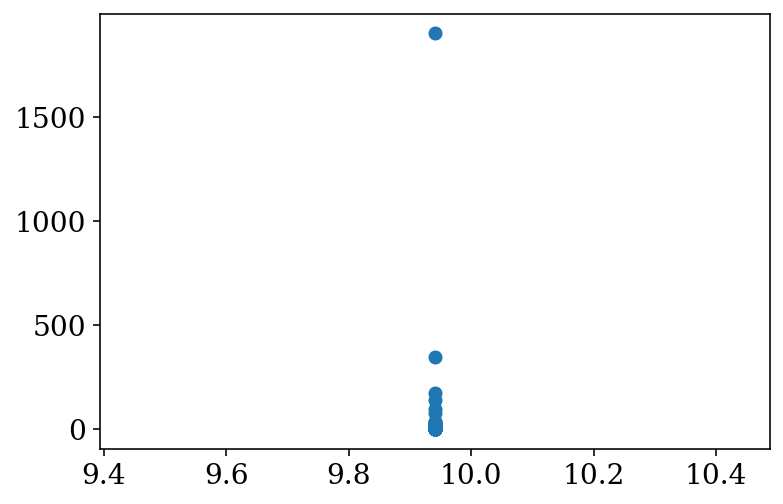

In [183]:
plt.scatter(peak_affinities,all_peaks)